In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [105]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv1D, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional, RepeatVector, TimeDistributed
from keras import regularizers
from datetime import datetime
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
pip install pydrive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
Cars = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data_set/CARS.csv', index_col=0)
img= pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data_set/IMG.csv', index_col=0)

In [36]:
x, y= Cars.to_numpy(), img.to_numpy()
train_size= int(0.7*x.shape[0])
x_train, x_test=x[0:train_size+1], x[train_size+1:]
y_train, y_test=y[0:train_size+1], y[train_size+1:]

In [37]:
x_train, y_train= x_train.reshape((-1,640,1)), y_train.reshape((-1,640,1))
x_train.shape, y_train.shape

((2801, 640, 1), (2801, 640, 1))

In [53]:
steps= 640
feature=1
es =tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode= 'min', min_delta=0.0001, verbose=1)
mc = ModelCheckpoint('best_model_lstm8.h5', monitor='val_loss', mode='min', save_best_only=True)
rmse= tf.keras.metrics.RootMeanSquaredError()
tf.keras.backend.clear_session()
Model=Sequential()
Model.add(LSTM(units=30, return_sequences=True, input_shape=(steps,feature)))
Model.add(Dropout(0.2))
Model.add(LSTM(units=30, return_sequences=True))
Model.add(Dropout(0.2))
Model.add(TimeDistributed(Dense(units=1)))
rmse=tf.keras.metrics.RootMeanSquaredError(name='rmse')
Model.compile(optimizer='adam', loss= 'mse', metrics=[rmse])
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 640, 30)           3840      
_________________________________________________________________
dropout (Dropout)            (None, 640, 30)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 640, 30)           7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 640, 30)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 640, 1)            31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_lstm5=Model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1, callbacks=[es, mc], validation_split=0.2)

Epoch 1/50
224/224 [==============================] - 10s 45ms/step - loss: 0.0044 - rmse: 0.0667 - val_loss: 0.0040 - val_rmse: 0.0631
Epoch 2/50
224/224 [==============================] - 9s 42ms/step - loss: 0.0040 - rmse: 0.0636 - val_loss: 0.0035 - val_rmse: 0.0594
Epoch 3/50
224/224 [==============================] - 9s 42ms/step - loss: 0.0034 - rmse: 0.0586 - val_loss: 0.0026 - val_rmse: 0.0514
Epoch 4/50
224/224 [==============================] - 9s 42ms/step - loss: 0.0026 - rmse: 0.0509 - val_loss: 0.0019 - val_rmse: 0.0433
Epoch 5/50
224/224 [==============================] - 9s 42ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0014 - val_rmse: 0.0371
Epoch 6/50
224/224 [==============================] - 9s 42ms/step - loss: 0.0015 - rmse: 0.0393 - val_loss: 0.0011 - val_rmse: 0.0339
Epoch 7/50
224/224 [==============================] - 9s 42ms/step - loss: 0.0013 - rmse: 0.0366 - val_loss: 9.8399e-04 - val_rmse: 0.0314
Epoch 8/50
224/224 [==============================

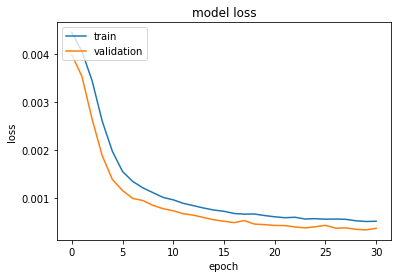

In [55]:
plt.plot(model_lstm5.history['loss'])
plt.plot(model_lstm5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [56]:
from keras.models import load_model
saved_model_lstm3 = load_model('best_model_lstm8.h5')

In [57]:
x_test, y_test= x_test.reshape((-1,640,1)), y_test.reshape((-1,640,1))

In [125]:
LSTM_valuation=saved_model_lstm3.evaluate(x_test, y_test, batch_size=10)
LSTM_valuation

120/120 [==============================] - 2s 20ms/step - loss: 3.2777e-04 - rmse: 0.0181


[0.00032776646548882127, 0.018104322254657745]

In [82]:
x_val, y_val= x_test[101].reshape((1,640,1)), y_test[101].reshape((1,640,1))
x_val.shape, y_val.shape

((1, 640, 1), (1, 640, 1))

In [83]:
y_prd= saved_model_lstm3.predict(x_val)
y_prd.dtype

dtype('float32')

In [84]:
y_prd=y_prd.astype(np.float64)
y_prd.shape

(1, 640, 1)

In [ ]:
df= pd.DataFrame({'x':x_val[0,:,0],'y':y_val[0,:,0], 'y_pred':y_prd[0,:,0]})
df

In [86]:
nu=np.random.uniform(0,1, 640)

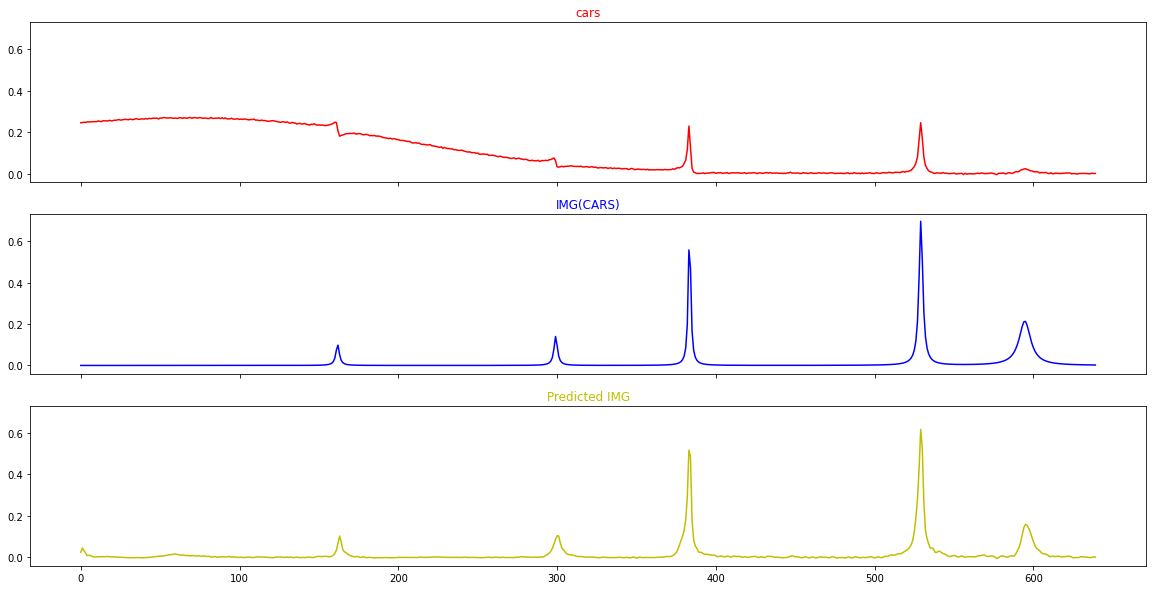

In [87]:
f, ax=plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,10))
ax[0].plot(x_val[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_val[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_prd[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
plt.show()

In [89]:
import CARS_generation
from CARS_generation import cars_generating

In [98]:
cars2=cars_generating(15,640)
data= cars2.generate_batch(1)
x= data[0]
y=data[1]
x.shape, y.shape

((1, 640), (1, 640))

In [99]:
x_gen, y_gen= x.reshape((-1,640,1)), y.reshape((-1,640,1))
y_pred=saved_model_lstm3.predict(x_gen)

In [100]:
x_gen.shape, y_gen.shape, y_pred.shape

((1, 640, 1), (1, 640, 1), (1, 640, 1))

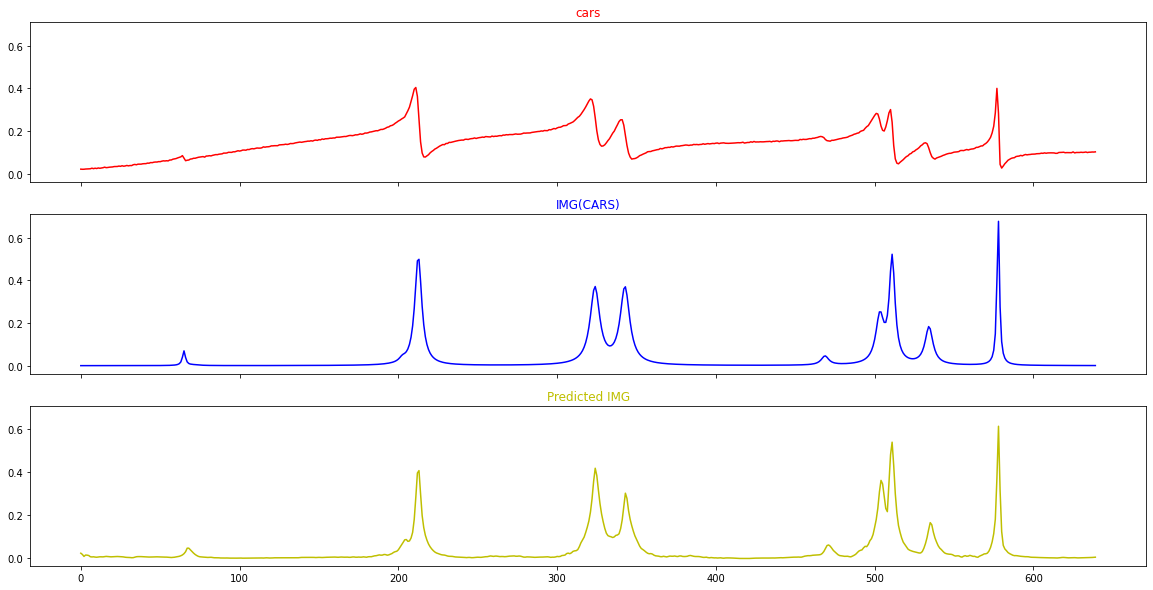

In [101]:
f, ax=plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,10))
ax[0].plot(x_gen[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_gen[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_pred[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
plt.show()

### **CNN+LSTM**

In [102]:
X_train, Y_train = x_train.reshape((-1,640)), y_train.reshape((-1,640))

In [107]:
es1 =tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6)
rmse1= tf.keras.metrics.RootMeanSquaredError()
mc1 = ModelCheckpoint('best_model_CCN_lstm.h5', monitor='val_loss', mode='min', save_best_only=True)

In [106]:
tf.keras.backend.clear_session()
input_layer = Input(shape=(x_train.shape[1], 1))
conv1 = Conv1D(filters=64,
               kernel_size=32,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2= Conv1D(filters=32, kernel_size=16, activation='relu', padding='same')(conv1)
lstm1 = LSTM(32, return_sequences=True)(conv2)
lstm2=LSTM(32,return_sequences=True)(lstm1)
output_layer = Dense(1)(lstm2)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss= 'mse', metrics=[rmse1])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 640, 64)           2112      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 640, 32)           32800     
_________________________________________________________________
lstm (LSTM)                  (None, 640, 32)           8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 640, 32)           8320      
_________________________________________________________________
dense (Dense)                (None, 640, 1)            33        
Total params: 51,585
Trainable params: 51,585
Non-trainable params: 0
__________________________________________________

In [108]:
mdoel_history= model.fit(x_train, y_train, epochs=50, batch_size=256, verbose=1, validation_split=0.2, callbacks=[es1, mc1])

Epoch 1/50
9/9 [==============================] - 1s 152ms/step - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 2/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 3/50
9/9 [==============================] - 1s 74ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 4/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 5/50
9/9 [==============================] - 1s 73ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 6/50
9/9 [==============================] - 1s 73ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0014 - val_root_mean_squared

In [110]:
saved_model_CNN_Lstm = load_model('best_model_CCN_lstm.h5')

In [126]:
CNN_LSTM_valuation=saved_model_CNN_Lstm.evaluate(x_test, y_test, batch_size=256)
CNN_LSTM_valuation

5/5 [==============================] - 0s 34ms/step - loss: 2.1042e-04 - root_mean_squared_error: 0.0145


[0.00021042308071628213, 0.014505967497825623]

In [118]:
x_cl, y_cl= x_test[10].reshape((1,640)), y_test[10].reshape((1,640))
x_cl.shape, y_cl.shape

((1, 640), (1, 640))

In [119]:
y_cl_pred= saved_model_CNN_Lstm.predict(x_cl)
y_cl_pred.shape

(1, 640, 1)

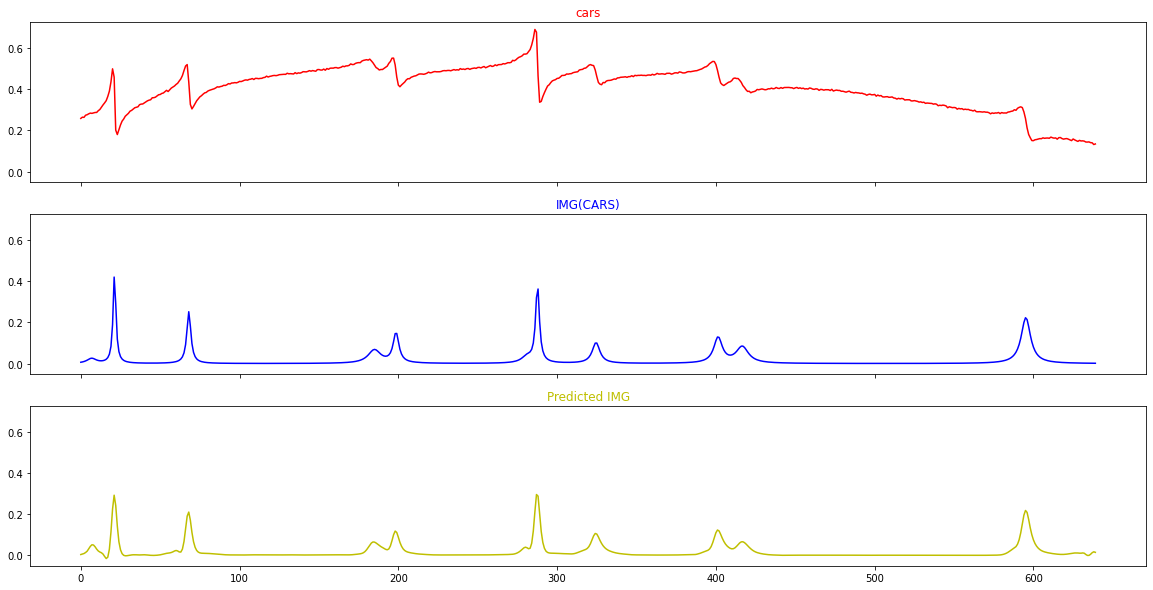

In [120]:
f, ax=plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,10))
ax[0].plot(x_cl[0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_cl[0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_cl_pred[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
plt.show()

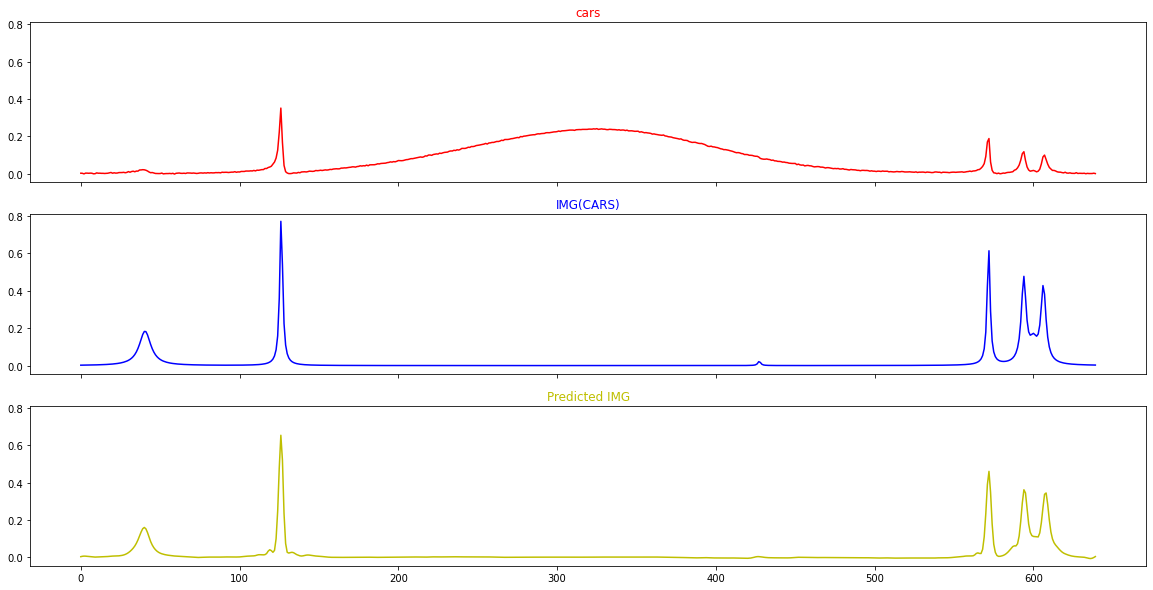

In [124]:
cars3=cars_generating(15,640)
data= cars2.generate_batch(1)
x= data[0]
y=data[1]
Y= saved_model_CNN_Lstm.predict(x)
f, ax=plt.subplots(3,1, sharex=True, sharey=True, figsize=(20,10))
ax[0].plot(x[0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y[0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(Y[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
plt.show()

In [144]:
pd.options.display.float_format = '{:.4f}'.format
Result= pd.DataFrame([LSTM_valuation, CNN_LSTM_valuation], columns=['Loss', 'Rmse'], index=['Lstm', 'CNN+Lstm'])
Result

Loss   Rmse
Lstm     0.0003 0.0181
CNN+Lstm 0.0002 0.0145

In [145]:
epoch=[31,50]
N_samples= [4000, 4000]
Test_train_split= ['70%', '70%']
validation_split= ['20%', '20%']
optimizer= ['Adam', 'Adam']
df= pd.DataFrame({"epoch":epoch, "n_samples": N_samples, 
                  "test_train_split": Test_train_split, 
                  "validation_split": validation_split, "optimizer": optimizer}, index=['Lstm', 'CNN+Lstm'])
df


epoch  n_samples test_train_split validation_split optimizer
Lstm         31       4000              70%              20%      Adam
CNN+Lstm     50       4000              70%              20%      Adam

In [146]:
df['Loss']=Result['Loss']
df['Rmse']= Result['Rmse']
Result=df
Result

epoch  n_samples test_train_split  ... optimizer   Loss   Rmse
Lstm         31       4000              70%  ...      Adam 0.0003 0.0181
CNN+Lstm     50       4000              70%  ...      Adam 0.0002 0.0145

[2 rows x 7 columns]

In [147]:
Result.to_excel("Result.xls")